In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.21.0


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 144MB/s] 


In [ ]:
!pip install -q gdown
%cd {HOME}
!gdown '1ODtJQAjiTHDaXyuO-CacaKmvMnZ6WJi2'

/content
Downloading...
From (original): https://drive.google.com/uc?id=1ODtJQAjiTHDaXyuO-CacaKmvMnZ6WJi2
From (redirected): https://drive.google.com/uc?id=1ODtJQAjiTHDaXyuO-CacaKmvMnZ6WJi2&confirm=t&uuid=959525a0-8b74-4298-b13f-858213659658
To: /content/highway.mp4
100% 219M/219M [00:06<00:00, 32.4MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/highway.mp4"

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - person
selected_classes = [0]


0: 736x1280 3 persons, 5 cars, 3 motorcycles, 1 traffic light, 1 kite, 2369.7ms
Speed: 59.7ms preprocess, 2369.7ms inference, 42.3ms postprocess per image at shape (1, 3, 736, 1280)


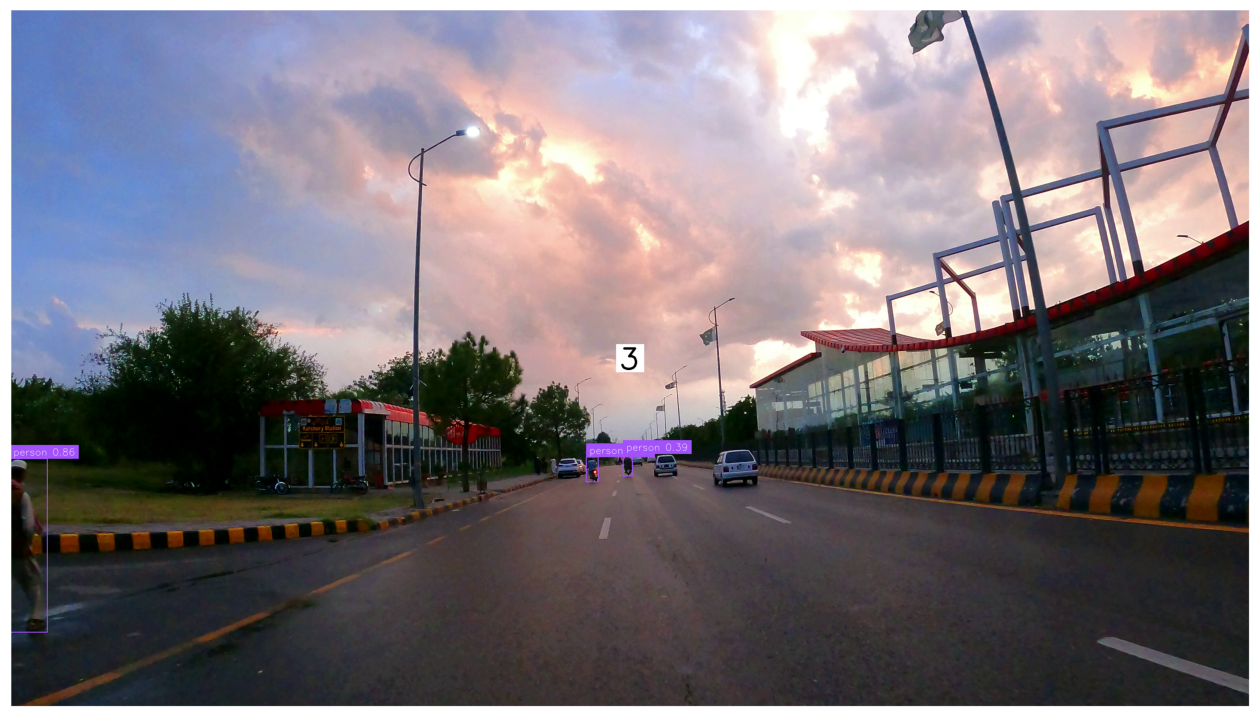

In [ ]:
import numpy as np
import supervision as sv

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_width, frame_height = video_info.width, video_info.height

# initiate polygon zone
polygon = np.array([
    [0, 0],
    [frame_width, 0],
    [frame_width, frame_height],
    [0, frame_height]
])
zone = sv.PolygonZone(polygon=polygon)

# initiate annotators
box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.WHITE, thickness=6, text_thickness=6, text_scale=3)

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [ ]:
import numpy as np
import supervision as sv

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_width, frame_height = video_info.width, video_info.height

# initiate polygon zone
polygon = np.array([
    [0, 0],
    [frame_width, 0],
    [frame_width, frame_height],
    [0, frame_height]
])
zone = sv.PolygonZone(polygon=polygon)

# initiate annotators
box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.WHITE, thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections)
    frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path=f"{HOME}/highway-people-counting-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()

Deploy

In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00


In [2]:
streamlit hello

SyntaxError: invalid syntax (<ipython-input-2-c7a1b683aa76>, line 1)